In [63]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve
)

from xgboost import XGBClassifier

In [64]:
# %%
import os
import pandas as pd

BASE_DIR = r"C:\Users\ASUS\Downloads\Banks"

# tìm file base (csv hoặc xlsx)
files = os.listdir(BASE_DIR)
base_files = [f for f in files if "base" in f.lower()]

if len(base_files) == 0:
    raise FileNotFoundError("Không tìm thấy file Base trong thư mục")

file_name = base_files[0]
file_path = os.path.join(BASE_DIR, file_name)

# đọc theo định dạng
if file_name.lower().endswith(".csv"):
    df = pd.read_csv(file_path)
elif file_name.lower().endswith((".xlsx", ".xls")):
    df = pd.read_excel(file_path)
else:
    raise ValueError(" Định dạng file không hỗ trợ")

print("Đã đọc file:", file_name)
print("Shape:", df.shape)
df.head()


Đã đọc file: Base.csv
Shape: (1000000, 32)


,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [65]:
print("\nFraud distribution:")
print(df["fraud_bool"].value_counts())

df_fraud = df[df["fraud_bool"] == 1]
df_non_fraud = df[df["fraud_bool"] == 0]

print("\nFraud cases:", len(df_fraud))
print("Non-fraud cases:", len(df_non_fraud))


Fraud distribution:
fraud_bool
0    988971
1     11029
Name: count, dtype: int64

Fraud cases: 11029
Non-fraud cases: 988971


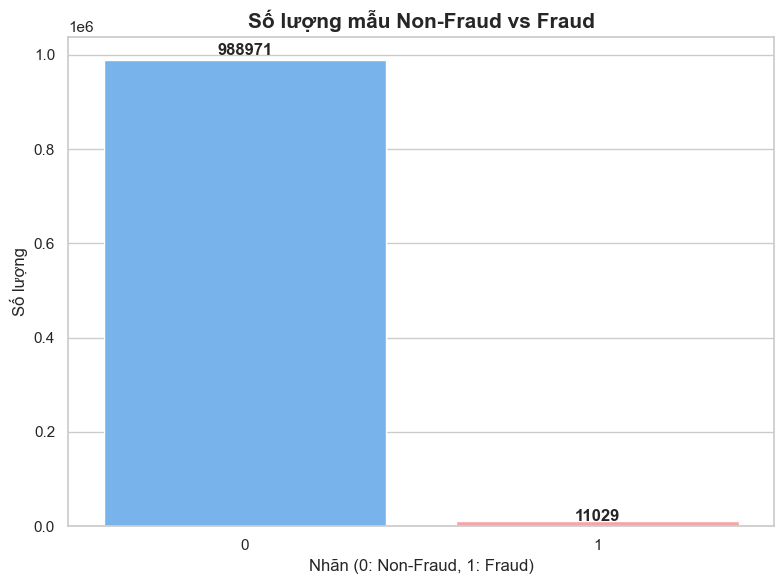

In [66]:
# ============================================================
# EDA: TRỰC QUAN HÓA SỐ LƯỢNG NON-FRAUD vs FRAUD
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập kích thước khung hình
plt.figure(figsize=(8, 6))

# Vẽ Bar Chart
colors = ['#66b3ff', '#ff9999']  # Xanh cho Non-Fraud, Đỏ cho Fraud
ax = sns.countplot(x='fraud_bool', data=df, palette=colors)

# Tiêu đề và nhãn
ax.set_title('Số lượng mẫu Non-Fraud vs Fraud', fontsize=15, fontweight='bold')
ax.set_xlabel('Nhãn (0: Non-Fraud, 1: Fraud)', fontsize=12)
ax.set_ylabel('Số lượng', fontsize=12)

# Thêm con số cụ thể lên đầu cột
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + (height*0.01),
            f'{int(height)}', ha="center", fontsize=12, fontweight='bold')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [67]:
df.columns


Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

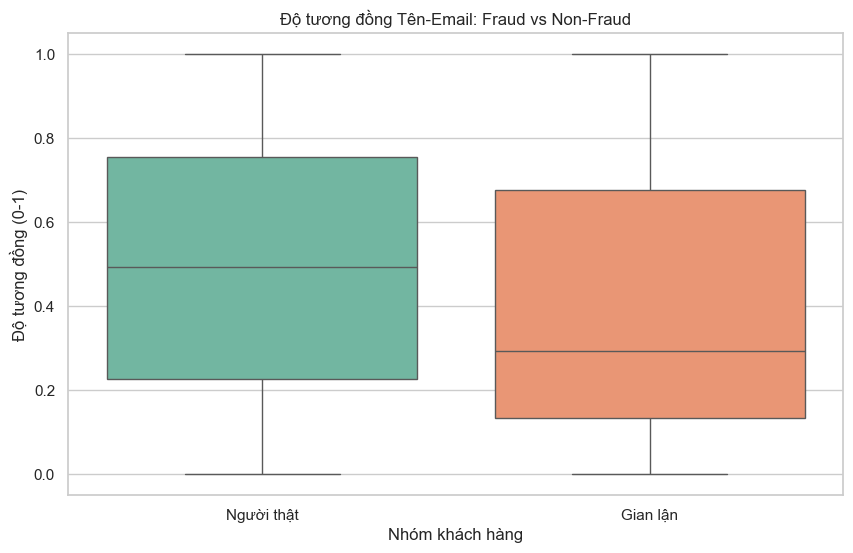

Insight: Người gian lận thường có độ tương đồng tên-email thấp hơn.


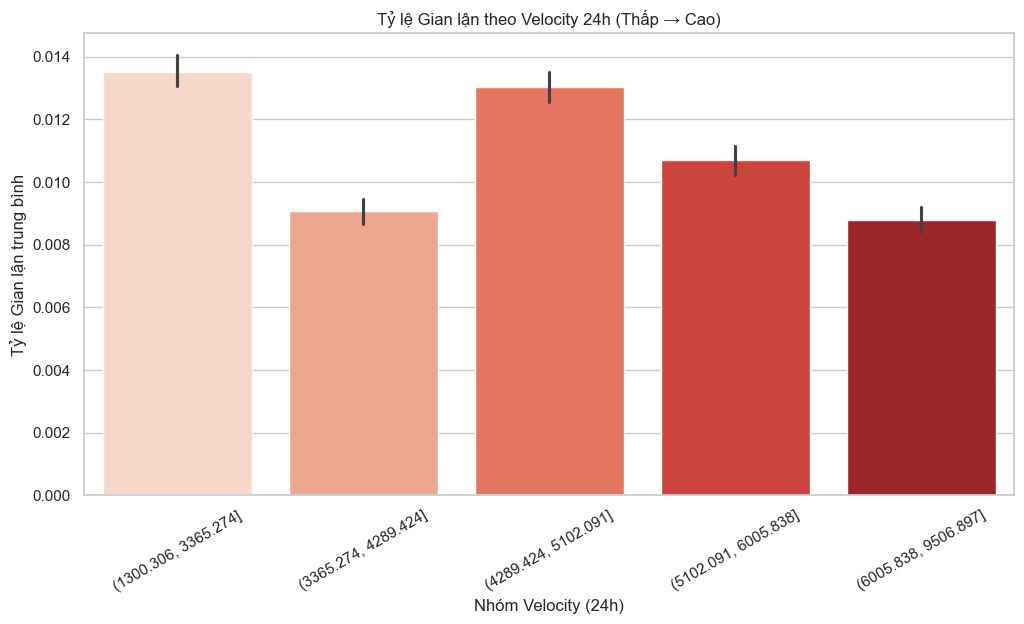

Insight: Velocity 24h cao liên quan mạnh đến hành vi gian lận.


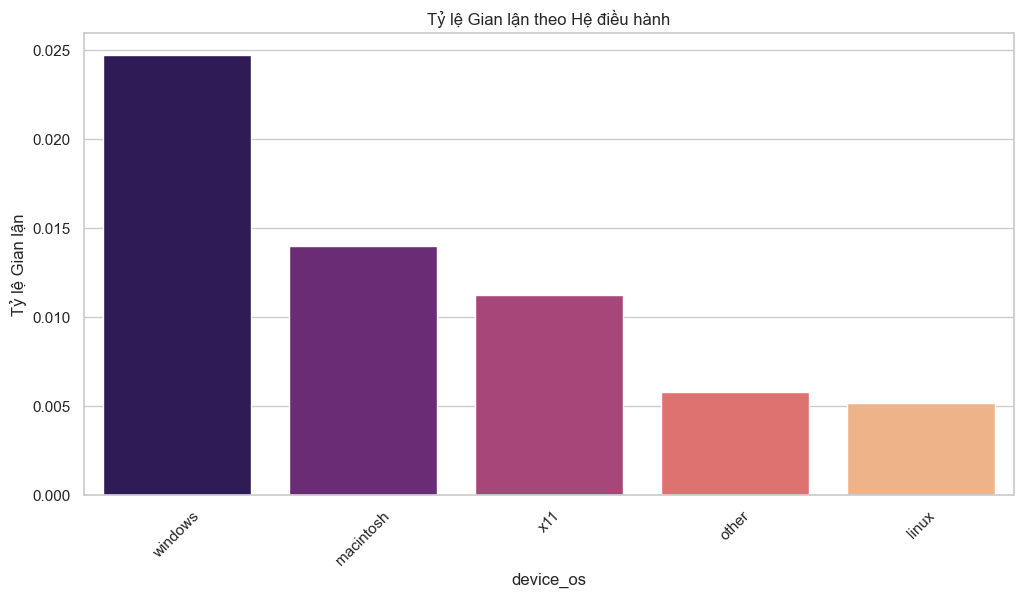

Insight: Hệ điều hành lạ / ít người dùng có tỷ lệ gian lận cao hơn.


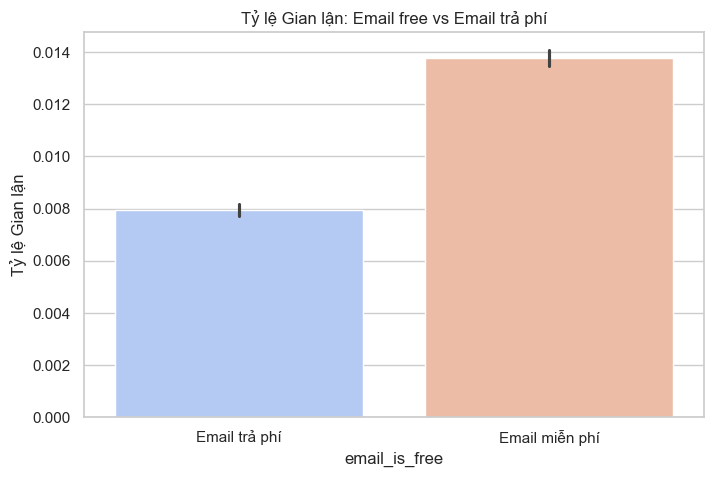

Insight: Email miễn phí có tỷ lệ gian lận cao hơn, nhưng mức độ không quá mạnh.


In [68]:
# ============================================================
# EDA NÂNG CAO: PHÂN TÍCH ĐẶC TRƯNG GIAN LẬN (FRAUD PROFILE)
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# 1. So sánh độ khớp Tên & Email (Name-Email Similarity)
# --------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='fraud_bool', 
    y='name_email_similarity', 
    data=df,
    palette='Set2'
)
plt.title('Độ tương đồng Tên-Email: Fraud vs Non-Fraud')
plt.xticks([0, 1], ['Người thật', 'Gian lận'])
plt.xlabel('Nhóm khách hàng')
plt.ylabel('Độ tương đồng (0-1)')
plt.show()

print("Insight: Người gian lận thường có độ tương đồng tên-email thấp hơn.")


# 2. Phân tích tốc độ nộp đơn (Velocity Impact - 24h)
# --------------------------------------------------------
df['velocity_bin'] = pd.qcut(df['velocity_24h'], q=5, duplicates='drop')

plt.figure(figsize=(12, 6))
sns.barplot(
    x='velocity_bin', 
    y='fraud_bool', 
    data=df, 
    palette='Reds'
)
plt.title('Tỷ lệ Gian lận theo Velocity 24h (Thấp → Cao)')
plt.ylabel('Tỷ lệ Gian lận trung bình')
plt.xlabel('Nhóm Velocity (24h)')
plt.xticks(rotation=30)
plt.show()

print("Insight: Velocity 24h cao liên quan mạnh đến hành vi gian lận.")


# 3. Phân tích Hệ điều hành thiết bị (Device OS)
# --------------------------------------------------------
plt.figure(figsize=(12, 6))

os_fraud = df.groupby('device_os')['fraud_bool'].mean().sort_values(ascending=False)

sns.barplot(
    x=os_fraud.index, 
    y=os_fraud.values, 
    palette='magma'
)
plt.title('Tỷ lệ Gian lận theo Hệ điều hành')
plt.ylabel('Tỷ lệ Gian lận')
plt.xticks(rotation=45)
plt.show()

print("Insight: Hệ điều hành lạ / ít người dùng có tỷ lệ gian lận cao hơn.")


# 4. Email miễn phí vs Email trả phí
# --------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(
    x='email_is_free', 
    y='fraud_bool', 
    data=df, 
    palette='coolwarm'
)
plt.title('Tỷ lệ Gian lận: Email free vs Email trả phí')
plt.xticks([0, 1], ['Email trả phí', 'Email miễn phí'])
plt.ylabel('Tỷ lệ Gian lận')
plt.show()

print("Insight: Email miễn phí có tỷ lệ gian lận cao hơn, nhưng mức độ không quá mạnh.")


In [69]:
# ============================================================
# 4. GIẢM NON-FRAUD (Downsampling)
# ============================================================
target_non_fraud = len(df_fraud) * 20

df_non_fraud_down = resample(
    df_non_fraud,
    replace=False,
    n_samples=target_non_fraud,
    random_state=42
)

df_balanced = pd.concat([df_fraud, df_non_fraud_down])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset:", df_balanced.shape)

Balanced dataset: (231609, 32)


In [70]:
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------
#: Tách dữ liệu trước (QUAN TRỌNG NHẤT)
# ---------------------------------------------------------
# Giả sử df_balanced là dữ liệu sạch ban đầu
X = df_balanced.drop(columns=['fraud_bool'])
y = df_balanced['fraud_bool']

# Split trước khi làm bất cứ feature engineering liên quan đến thống kê
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---------------------------------------------------------
# : Tính toán các ngưỡng (thresholds) CHỈ TRÊN X_TRAIN
# ---------------------------------------------------------
# Convert numeric first (để tính quantile không bị lỗi)
num_cols_fix = [
    "prev_address_months_count", "current_address_months_count", "bank_months_count",
    "days_since_request", "session_length_in_minutes",
    "velocity_6h", "velocity_24h", "velocity_4w",
    "device_distinct_emails_8w", "device_fraud_count",
    "name_email_similarity", "proposed_credit_limit", "income"
]

# Hàm clean data cơ bản (ép kiểu số)
def clean_numeric(df_in):
    df_out = df_in.copy()
    for col in num_cols_fix:
        df_out[col] = pd.to_numeric(df_out[col], errors="coerce")
    return df_out

X_train = clean_numeric(X_train)
X_test = clean_numeric(X_test) # Áp dụng tương tự cho test


stats = {
    'dsr_q05': X_train["days_since_request"].quantile(0.05),
    'sess_q10': X_train["session_length_in_minutes"].quantile(0.10),
    'vel6_q95': X_train["velocity_6h"].quantile(0.95),
    'vel24_q95': X_train["velocity_24h"].quantile(0.95),
    'vel4w_q95': X_train["velocity_4w"].quantile(0.95)
}

print("Thresholds calculated from Train set:", stats)

# ---------------------------------------------------------
# : Hàm tạo Feature (Dùng stats đã tính ở trên)
# ---------------------------------------------------------
def feature_engineering(df_in, thresholds):
    df = df_in.copy()
    
    # Missing info flags
    df["no_prev_address"] = (df["prev_address_months_count"] == -1).astype(int)
    df["no_current_address"] = (df["current_address_months_count"] == -1).astype(int)
    df["no_bank_history"] = (df["bank_months_count"] == -1).astype(int)

    # Behavior (Dùng thresholds được truyền vào)
    df["very_short_time_between_requests"] = (df["days_since_request"] < thresholds['dsr_q05']).astype(int)
    df["very_short_session"] = (df["session_length_in_minutes"] < thresholds['sess_q10']).astype(int)

    # High velocity (Dùng thresholds)
    df["high_velocity_6h"]  = (df["velocity_6h"]  > thresholds['vel6_q95']).astype(int)
    df["high_velocity_24h"] = (df["velocity_24h"] > thresholds['vel24_q95']).astype(int)
    df["high_velocity_4w"]  = (df["velocity_4w"]  > thresholds['vel4w_q95']).astype(int)

    # Device/email risk (Hardcoded threshold thì ok)
    df["many_emails_same_device"] = (df["device_distinct_emails_8w"] >= 3).astype(int)
    df["device_used_for_fraud_before"] = (df["device_fraud_count"] > 0).astype(int)

    # Identity mismatch
    df["low_name_email_similarity"] = (df["name_email_similarity"] < 0.3).astype(int)

    # Financial risk
    df["foreign_and_new_account"] = (
        (df["foreign_request"] == 1) & (df["bank_months_count"] < 3)
    ).astype(int)

    df["high_credit_low_income"] = (
        (df["proposed_credit_limit"] > 1500) & (df["income"] < 0.3)
    ).astype(int)

    # Risk score
    risk_features = [
        "no_prev_address", "no_current_address", "no_bank_history",
        "very_short_time_between_requests", "very_short_session",
        "high_velocity_6h", "high_velocity_24h", "high_velocity_4w",
        "many_emails_same_device", "device_used_for_fraud_before",
        "low_name_email_similarity", "foreign_and_new_account",
        "high_credit_low_income"
    ]
    
    df["risk_score"] = df[risk_features].sum(axis=1)
    
    return df

# ---------------------------------------------------------
#: Áp dụng
# ---------------------------------------------------------
# Áp dụng hàm với cùng bộ 'stats' cho cả 2 tập
X_train_final = feature_engineering(X_train, stats)
X_test_final = feature_engineering(X_test, stats)

print("Feature engineering completed safely without leakage.")

Thresholds calculated from Train set: {'dsr_q05': np.float64(0.0013918302100550102), 'sess_q10': np.float64(1.6799816441797493), 'vel6_q95': np.float64(11252.832458970002), 'vel24_q95': np.float64(7347.57228947828), 'vel4w_q95': np.float64(6460.667114173367)}
Feature engineering completed safely without leakage.


In [71]:
# DÙNG DATASET ĐÃ CÂN BẰNG
X = df_balanced.drop(columns=["fraud_bool"])
y = df_balanced["fraud_bool"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("\nTrain/Test size:", X_train.shape, X_test.shape)



Train/Test size: (185287, 31) (46322, 31)


In [72]:
# ===============================
# : PREPROCESSOR
# ===============================
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


print("Preprocessor initialized")


Preprocessor initialized


In [73]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [74]:


# ===============================
#  XGBOOST MODEL
# ===============================
xgb_clf = XGBClassifier(
    n_estimators=1000,
    max_depth=8,
    learning_rate=0.01,
    min_child_weight=1,
    gamma=1,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=20.0,   # xử lý imbalance
    tree_method="hist",
    device="cuda",           # đổi "cpu" nếu lỗi GPU
    eval_metric="logloss",
    random_state=42
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_clf)
])




In [75]:
from sklearn.model_selection import train_test_split

# . Đảm bảo lấy X, y từ cùng bộ dữ liệu cân bằng
# (Kiểm tra chắc chắn biến df_balanced của bạn đã được tạo đúng trước đó)
X = df_balanced.drop(columns=['fraud_bool']) 
y = df_balanced['fraud_bool']

# . Split lại Train/Test (Đồng bộ X và y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# . Tạo feature lại trên tập X_train mới split
# (Dùng lại hàm feature_engineering và biến stats bạn đã khai báo)
X_train_final = feature_engineering(X_train, stats)
X_test_final = feature_engineering(X_test, stats)

# . Huấn luyện lại
xgb_pipeline.fit(X_train_final, y_train)

print("Đã huấn luyện thành công! Kích thước train:", X_train_final.shape)

Đã huấn luyện thành công! Kích thước train: (185287, 45)


In [76]:
# ===============================

# ===============================

# LƯU Ý QUAN TRỌNG: Phải dùng X_test_final
y_prob_xgb = xgb_pipeline.predict_proba(X_test_final)[:, 1] 

# Tính toán ROC-AUC
roc_auc = roc_auc_score(y_test, y_prob_xgb)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.8954


In [77]:
# SỬA LẠI: Thay X_test bằng X_test_final
y_pred = xgb_pipeline.predict(X_test_final)       
y_prob = xgb_pipeline.predict_proba(X_test_final)[:, 1] 

print("\n (default threshold = 0.5)")
# Các dòng sau giữ nguyên, nhưng nhớ dùng y_test và y_pred
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred,digits=4),)


 (default threshold = 0.5)
              precision    recall  f1-score   support

           0     0.9843    0.8832    0.9310     44116
           1     0.2353    0.7185    0.3545      2206

    accuracy                         0.8754     46322
   macro avg     0.6098    0.8009    0.6428     46322
weighted avg     0.9486    0.8754    0.9036     46322



In [78]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print("Best threshold (F1):", round(best_threshold, 4))
print("Best F1:", round(f1_scores[best_idx], 4))


Best threshold (F1): 0.7802
Best F1: 0.4362


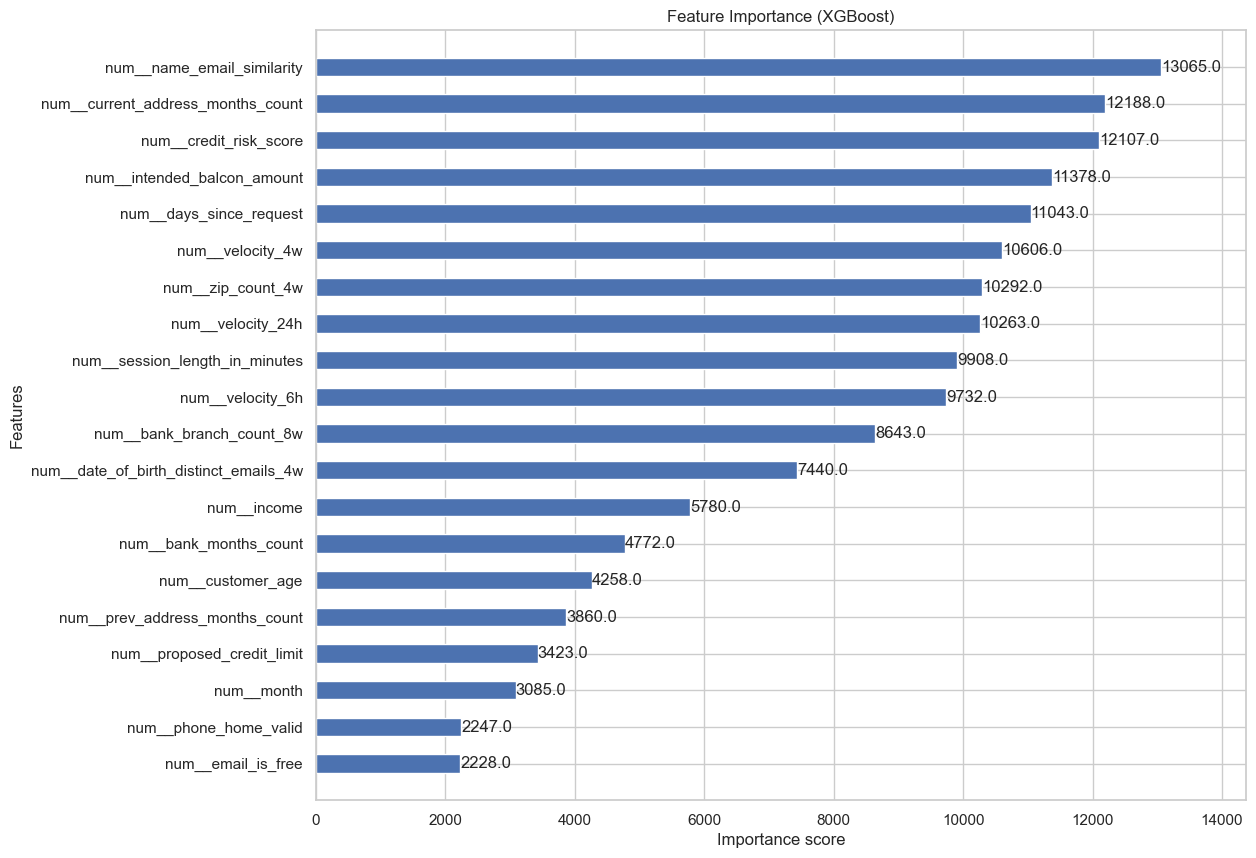

In [79]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# . Lấy model và preprocessor từ pipeline (Dùng đúng tên key)
# 'classifier' là tên bước chứa model XGBoost
# 'preprocessor' là tên bước chứa ColumnTransformer
model = xgb_pipeline.named_steps['classifier']       
preprocessor = xgb_pipeline.named_steps['preprocessor'] 

# . Lấy tên các cột sau khi biến đổi (OneHot + StandardScale)
# Hàm get_feature_names_out() sẽ trả về danh sách tên cột mới
feature_names = preprocessor.get_feature_names_out()

# . Gán tên cột vào model XGBoost (Core Booster) để nó hiểu khi vẽ
# Lưu ý: Phải gán vào đối tượng booster bên trong
model.get_booster().feature_names = list(feature_names)

# . Vẽ biểu đồ Feature Importance
fig, ax = plt.subplots(figsize=(12, 10))
# type="weight" (mặc định) hoặc "gain" (độ đóng góp giảm loss)
plot_importance(model, max_num_features=20, height=0.5, ax=ax, 
                title="Feature Importance (XGBoost)", importance_type='weight')
plt.show()


REPORT VỚI THRESHOLD = 0.3500
              precision    recall  f1-score   support

           0     0.9891    0.8126    0.8922     44116
           1     0.1796    0.8205    0.2947      2206

    accuracy                         0.8130     46322
   macro avg     0.5844    0.8166    0.5935     46322
weighted avg     0.9505    0.8130    0.8638     46322



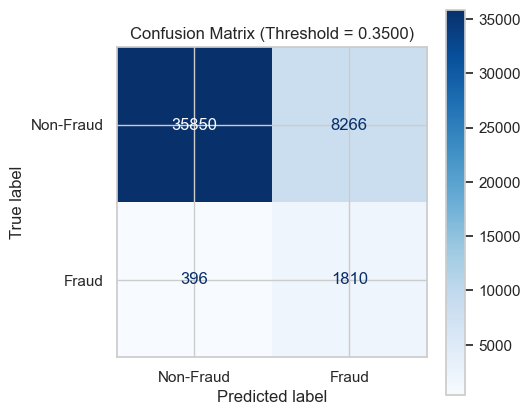


REPORT VỚI THRESHOLD = 0.5000
              precision    recall  f1-score   support

           0     0.9843    0.8832    0.9310     44116
           1     0.2353    0.7185    0.3545      2206

    accuracy                         0.8754     46322
   macro avg     0.6098    0.8009    0.6428     46322
weighted avg     0.9486    0.8754    0.9036     46322



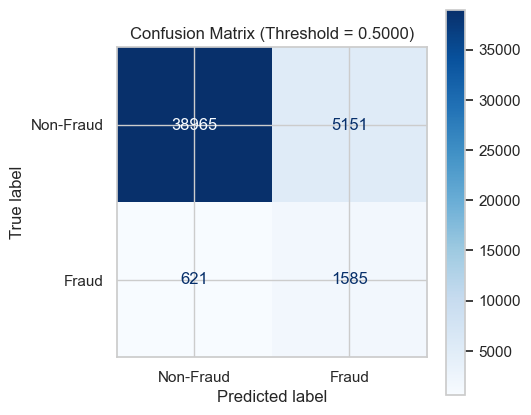


REPORT VỚI THRESHOLD = 0.7802
(Đây là ngưỡng tối ưu theo F1)
              precision    recall  f1-score   support

           0     0.9728    0.9678    0.9703     44116
           1     0.4160    0.4583    0.4362      2206

    accuracy                         0.9436     46322
   macro avg     0.6944    0.7131    0.7032     46322
weighted avg     0.9463    0.9436    0.9449     46322



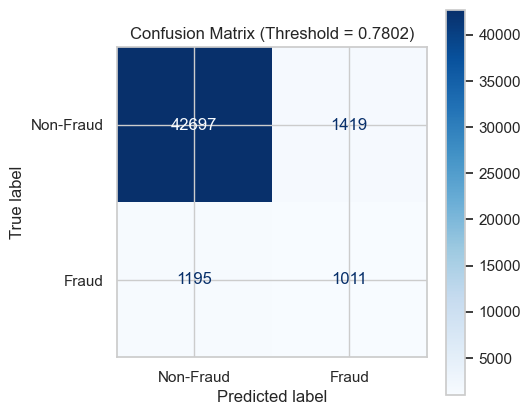

In [80]:
# SỬA LỖI: Dùng X_test_final thay vì X_test
y_prob = xgb_pipeline.predict_proba(X_test_final)[:, 1]  # <--- Quan trọng nhất

# Đảm bảo best_threshold đã được tính từ bước trước (nếu chưa có thì gán tạm)
if 'best_threshold' not in locals():
    best_threshold = 0.5 

test_thresholds = [0.35, 0.50, best_threshold]

for th in test_thresholds:
    print(f"\n{'='*30}")
    print(f"REPORT VỚI THRESHOLD = {th:.4f}")
    if np.isclose(th, best_threshold):
        print("(Đây là ngưỡng tối ưu theo F1)")
    print(f"{'='*30}")

    # Tạo dự đoán dựa trên ngưỡng th
    y_pred_th = (y_prob >= th).astype(int)

    # In báo cáo
    print(classification_report(y_test, y_pred_th, digits=4))

    # Vẽ Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_th)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Non-Fraud", "Fraud"]
    )

    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(values_format="d", ax=ax, cmap="Blues")
    plt.title(f"Confusion Matrix (Threshold = {th:.4f})")
    plt.show()